In [1]:
import os
import json
import random
import string
from typing import Annotated, TypedDict, List, Sequence, Optional
from langchain_groq import ChatGroq 
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.types import Command
from langchain_core.messages import BaseMessage,HumanMessage,SystemMessage,AIMessage,ToolMessage
from langgraph.graph.message import add_messages
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, InjectedState, tools_condition
from dotenv import load_dotenv

In [2]:
load_dotenv()
api_key = os.getenv("GROQ_API_KEY")

In [3]:
llm = ChatGroq(model="llama-3.1-8b-instant")

In [39]:
class SupervisorState(MessagesState):
    """
        State for multi-agent system
    """   
    user_input: str
    user_intent: str
    complaint: dict
    missing_info: list
    next: str
    questions: str

# Supervisor Node

def supervisor_node(state:SupervisorState)->SupervisorState:

    if state.get('complaint_in_progress'):
        return Command(goto="Complaint Agent")
 
    system_prompt = """
    You are a supervisor. Classify the user query into one of: inquiry, complaint, retention.

    Rules:
    - If the user mentions cancelling, switching, leaving, or expresses strong frustration about continuing the service, classify as retention.
    - If the user complains but does not express intent to leave, classify as complaint.
    - If the user is asking for info or guidance, classify as inquiry.

    Examples:
    - "My laptop stopped working" -> complaint
    - "Show me more info on my TCL TV" -> inquiry
    - "I want to cancel my Netflix subscription" -> retention
    - "My smartphone battery is not charging" -> complaint
    - "I want to know the specs of my AirPods" -> inquiry
    - "I want to cancel my gym membership" -> retention
    - "My last order was delayed and I am frustrated, considering switching" -> retention
    - "The app crashes often, this is annoying" -> complaint
    - "Where can I see my last invoice?" -> inquiry

    Return **only** the intent.
    """
    
    response = llm.invoke([
        {"role":"system", "content":system_prompt},
        {"role":"user", "content":state["user_input"]}
        ])
    
    intent=response.content.strip().lower()
    state['user_intent']=intent

    if intent=="inquiry":
        return Command(goto="Inquiry Agent")
    elif intent=="complaint":
        return Command(goto="Complaint Agent")
    elif intent=="retention":
        return Command(goto="Retention Agent")
    else:
        return Command(goto="Fallback")


In [5]:
# Worker nodes

def inquiry_node(state:SupervisorState)->SupervisorState:
    return {'messages':[f"Inquiry Handled: {state['user_input']}"]}

def fallback(state:SupervisorState)->SupervisorState:
    return {'messages':[f"Sorry, I couldn't understand your message"]}

In [ ]:
@tool
def nlu(user_input: str, complaint:Optional[dict])->dict:
    """It extracts the entities from the user input"""

    system_prompt=f"""
    You are an entity extractor. 
    The current state of collected complaint data is: {complaint}.
    Your goal is to extract the latest product, issue_type, and purchase_date 
    from the user's input.
    - product
    - issue_type
    - purchase_date

    Respond ONLY with a valid JSON object in this exact format:
    {{
        "product": string or null,
        "issue_type": string or null,
        "purchase_date": MM/DD/YY or null
    }}
    """
    response = llm.invoke([
        SystemMessage(content=system_prompt),
        HumanMessage(content=user_input)
    ])
     
    return {"complaint": json.loads(response.content) }

@tool
def create_ticket(complaint: dict)->dict:
    """
    Tool to create a complaint ticket.
    Generates a ticket ID like IG408C90.
    """
    prefix = ''.join(random.choices(string.ascii_uppercase,k=2))
    number1 = random.randint(100,1000)
    mid = ''.join(random.choices(string.ascii_uppercase))
    number2 = random.randint(10,100)
    ticket_id = f"{prefix}{number1}{mid}{number2}"

    ticket={
        "ticket_id":ticket_id,
        "status":"created",
        "details":complaint
    }
    
    return ticket
    

In [7]:
tools = [nlu,create_ticket]
complaint_tool =  ToolNode(tools)

In [ ]:
def complaint_node(state:SupervisorState)->SupervisorState:
   """
      This node handles complaint and helps to resolve complaint.  
   """
   messages = state.get("messages",[])
   complaint_data = state.get("complaint",{})
   missing_info = state.get("missing_info",[])

   system_prompt = f"""
   You are a complaint resolution assistant. 

   - The current accumulated complaint data is: {complaint_data}. 
   - The fields currently missing are: {missing_info}.

   Your workflow is:
   - **CRITICAL INSTRUCTION:** When calling the 'nlu' tool, you MUST provide both the 'user_input' and the full 'complaint' dictionary as arguments.
   - **Phase 1: Data Gathering.**
      - Always start by calling 'nlu' on the current user input.
      - If the 'nlu' tool output shows that essential data is missing (product, issue_type, OR purchase_date), 
      **DO NOT CALL A TOOL**. Instead, you must respond *directly* to the user with a conversational question asking for *only* the missing information.
      - After receiving a user's answer, you must call 'nlu' again on the new user input to extract the new data.
   - **Phase 2: Ticket Creation.**
      - Once the 'nlu' tool output contains ALL required information (product, issue_type, AND purchase_date are NOT null), you must call 'create_ticket'.

   - **Crucial Rule for Clarification:** When you need to ask a question, ensure the question is conversational and **directly refers to the product and the missing field(s)** identified in the latest 'nlu' tool output.
   - Always use the **product name** (e.g., 'Mobile', 'Mouse') extracted in the last step when asking for missing details.
    """ 
    

   response = llm.bind_tools(tools).invoke(
    [SystemMessage(content=system_prompt)]+messages
   )
   new_messages = messages + [response]

   return {"messages":new_messages}

In [42]:
def nlu_node(state:SupervisorState)->SupervisorState:
   """ 
      NLU Extractor agent that extract entities (product, issue_type, and purchase_date) from user input. 
   """
   user_input = state["user_input"]

   system_prompt=f""" You are an entity extractor. 
   Your goal is to extract the latest product, issue_type, and purchase_date 
   from the user's input.
   - product
   - issue_type
   - purchase_date

   Respond ONLY with a valid JSON object in this exact format:
   {{
      "product": string or null,
      "issue_type": string or null,
      "purchase_date": MM/DD/YY or null
   }}
   """

   response = llm.invoke([
        SystemMessage(content=system_prompt),
        HumanMessage(content=user_input)
    ])
   
   state['complaint']=json.loads(response.content)
   
   return Command(goto=ask_missing_info)
   
def ask_missing_info(state:SupervisorState)->SupervisorState:
    """" 
        This Agent validate th data from NLU agent and ask missing information from user input.
    """
    complaint_data = state['complaint']
    user_input = state['user_input']
    missing_data = [k for k,v in complaint_data.items() if not v]

    system_prommpt = f"""You are a smart assistant.
    You will ask missing info to user. This is a list of missing info from user input {user_input}   
    This is missing list of information {missing_data}.
    """
    response = llm.invoke([
        SystemMessage(content=system_prommpt)]
    )
    state['questions']=response.content
    return Command(goto=ticket_node)

def ticket_node(state:SupervisorState)->SupervisorState:
    """
    Tool to create a complaint ticket.
    Generates a ticket ID like IG408C90.
    """

    complaint = state['complaint']
    
    prefix = ''.join(random.choices(string.ascii_uppercase,k=2))
    number1 = random.randint(100,1000)
    mid = ''.join(random.choices(string.ascii_uppercase))
    number2 = random.randint(10,100)
    ticket_id = f"{prefix}{number1}{mid}{number2}"

    ticket={
        "ticket_id":ticket_id,
        "status":"created",
        "details":complaint
    }
    

In [9]:
def merge_complaint(state:SupervisorState)->SupervisorState:
    """Reads the latest NLU tool output and merges it safely into the persistent 'complaint' state."""

    last_messages = state['messages'][-1]
    
    if not (isinstance(last_messages,ToolMessage) and last_messages.name=='nlu'):
        return state
    try:
        tool_output_dict = json.loads(last_messages.content)
        new_extracted_data = tool_output_dict.get("complaint",{})
        missing_info = [key for key,value in new_extracted_data.items() if value is None]
        
        current_complaint=state.get("complaint",{})
        merged_complaint=current_complaint.copy()

        for key, value in new_extracted_data.items():
            if value is not None:
                merged_complaint[key]=value
        print("////////////////")
        print(merged_complaint)
        print(missing_info)
        print("\\\\\\\\\\\\\\\\\\")
        state['complaint']=merged_complaint
        state['missing_info']=missing_info
        return state
    
    except (json.JSONDecodeError, KeyError) as e:
        print(f"Error merging NLU data: {e}")
        return state

In [10]:
builder = StateGraph(SupervisorState)
builder.add_node("ComplaintNode", complaint_node)
builder.add_node("tools",complaint_tool)
builder.add_node("Merge data",merge_complaint)

builder.add_edge(START,"ComplaintNode")
builder.add_conditional_edges(
    "ComplaintNode",
    tools_condition
)
builder.add_edge("tools","Merge data")
builder.add_edge("Merge data","ComplaintNode")
memory = MemorySaver()

build = builder.compile(checkpointer=memory)
config= {"configurable":{"thread_id":"user_complaint_session_A"}}

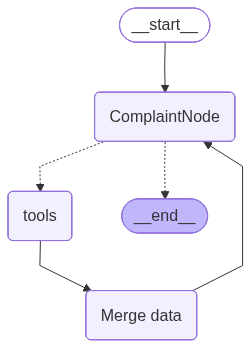

In [11]:
build

In [19]:
# response = build.invoke({"messages":"Mouse is not working."}, config=config)
response = build.invoke({"messages":"Today"}, config=config)

////////////////
{'product': 'Mouse', 'issue_type': 'not working', 'purchase_date': 'Today'}
[]
\\\\\\\\\


In [20]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Today
================================== Ai Message ==================================
Tool Calls:
  nlu (bekcww9yv)
 Call ID: bekcww9yv
  Args:
    complaint: {}
    user_input: Today
================================= Tool Message =================================
Name: nlu

{"complaint": {"product": null, "issue_type": null, "purchase_date": null}}
================================== Ai Message ==================================

We're still missing some information about your product. Could you please tell me what product you're experiencing issues with?
================================ Human Message =================================

Mouse is not working.
================================== Ai Message ==================================
Tool Calls:
  nlu (w628zk3cc)
 Call ID: w628zk3cc
  Args:
    complaint: {'issue_type': None, 'product': 'Mouse', 'purchase_date': None}
    user_input: Mouse is not work

In [21]:
print(response['messages'][-1].content)

Your complaint ticket has been created successfully. Your ticket ID is NM167S43. We will review your issue and get back to you soon.


In [ ]:
graph = StateGraph(SupervisorState)
graph.add_node("Supervisor",supervisor_node)
graph.add_node("Inquiry Agent",inquiry_node)
graph.add_node("Complaint Agent",complaint_tool)
graph.add_node("Retention Agent",retention_node)
graph.add_node("Fallback", fallback) 

graph.add_edge(START, "Supervisor")
graph.add_conditional_edges(
    "Supervisor",
    {
        "complaint": "Complaint Agent",
        "inquiry": "Inquiry Agent",
        "retention": "Retention Agent",
        "fallback": "Fallback" 
    }
)
graph.add_edge("Complaint Agent",END)

app = graph.compile()

NameError: name 'retention_node' is not defined

In [35]:
graph = StateGraph(SupervisorState)

graph.add_node("Supervisor", supervisor_node)
graph.add_node("Inquiry Agent", inquiry_node)
graph.add_node("Complaint Agent", complaint_tool)  # ToolNode
graph.add_node("Retention Agent", retention_node)
graph.add_node("Fallback", fallback)

graph.add_edge(START, "Supervisor")

# Conditional edges: keys = condition values in state, values = actual nodes (callables/Runnables)
graph.add_conditional_edges(
    "Supervisor",
    {
        "complaint": complaint_tool,        # pass the ToolNode directly
        "inquiry": inquiry_node,
        "retention": retention_node,
        "fallback": fallback
    }
)

# Once Complaint Agent completes → END
# graph.add_edge(complaint_tool, END)  # pass ToolNode, not string
app = graph.compile()

In [39]:
response = app.invoke({"user_input":"My mouse is not working. This is a complaint."})

40.0
Hi there, 

Sorry to hear that your mouse isn't working. I'd be happy to help you resolve the issue. Can you please try restarting your device and see if that fixes the problem? If not, I'll do my best to assist you further.


ValueError: No message found in input

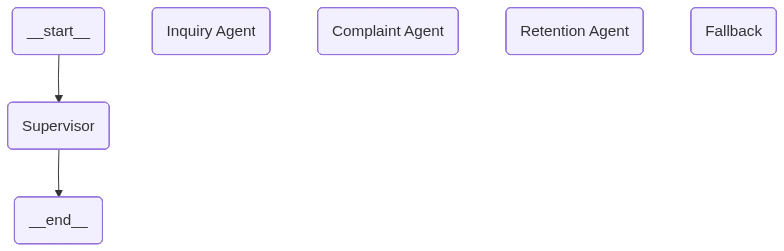

In [36]:
app

In [ ]:
response = app.invoke({"user_input":"Today."})
response

In [ ]:
@tool
def churn_score(user_input:str)->int:
    """
        Calculate a churn risk score from user input.
        Returns category: high, medium, or low.
    """

    system_prompt = """ 
    You are a churn detection assistant.
    Based on the user input, classifiy their churn risk into:
    - high: user explicitly wants to cancel, switch, or sounds very frustrated.
    - medium: user shows dissatisfaction but hasn't decided to cancel yet.
    - low: user just asking questions or mild complaints.

    Examples:
    User: "I'm cancelling this useless service today."
    Churn risk: high

    User: "Your prices keep going up, I don't know if it's worth it anymore."
    Churn risk: medium

    User: "How do I cancel if I ever need to in the future?"
    Churn risk: low

    Respond with only one of: high, medium, low.
    """
    score = llm.invoke([
        {'role':'system', 'content':system_prompt},
        {'role':'user', 'content':user_input}
    ]).content

    return str(score)

@tool
def loyalty_score(score:str)->str:
    """ 
        Provide rewards to user based on churn score. 
    """
    reward_weights = {'high': 1.0, "medium": 0.6, "low": 0.2}
    clv_values = {"high": 1000, "medium": 500, "low": 200}
    clv_tier=random.choices(
        ['high','medium','low'],
        weights=[0.25,0.45,0.3],
        k=1
    )[0]

    reward_score = reward_weights[score]*clv_values[clv_tier]

    return reward_score

@tool
def loyalty_rewards(user_input:str, reward_score:float, churn_score:str)->str:
    """
    Generate a personalized retention message.
    """
    system_prompt=""" 
    You are a customer retention assistant. 
    Generate a polite, empathetic message based on the following:
    - The user's message
    - Their churn risk (high, medium, low)
    - Their loyalty score (40-1000)

    Rules:
    - If loyalty score >= 800 → emphasize strong appreciation and give a high reward (e.g., big discount, free premium month).
    - If 500-799 → show gratitude and offer a medium reward (e.g., discount or perk).
    - If 200-499 → acknowledge their value and give a small reward (e.g., loyalty points or small discount).
    - If < 200 → do not give a reward, just apologize and promise to improve.
    - If churn risk = high → always start by apologizing and showing empathy before mentioning any reward.
    - Keep the message short, friendly, concise and natural. Do not include technical terms or scores.
    
    Respond with only the final concise message.
    """

    user_context = f"""
    User message: {user_input}
    Churn risk: {churn_score}
    Loyalty score: {reward_score}
    """

    response = llm.invoke([{'role':'system', 'content':system_prompt},
                           {'role':'user','content':user_context}]).content
    
    return str(response)


In [ ]:
def retention_node(state:SupervisorState)->SupervisorState:
    score = churn_score(state['user_input'])
    rewards = loyalty_score(score)
    loyalty=loyalty_rewards({'user_input':state['user_input'],'reward_score':rewards, 'churn_score':score})
    print(rewards)
    print(loyalty)
    return {'messages':[f"Retention Handled: {state['user_input']}"]}